<a href="https://colab.research.google.com/github/avasalya/data/blob/main/satellitev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pre-trained imagenet, lr =0.01, STEPS_PER_EPOCH = 200, VALIDATION_STEPS = 10, heads-> res4+ --> all_layers epochs 10,20,30, split 80 20



In [ ]:
# Import modules
import os
import re
import sys
import cv2
import time
import math
import random
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!pip uninstall keras -y
!pip install keras==2.1.5

# use TF 1.x with MASK_RCNN
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Uninstalling Keras-2.1.5:
  Successfully uninstalled Keras-2.1.5
  Using cached https://files.pythonhosted.org/packages/ba/65/e4aff762b8696ec0626a6654b1e73b396fcc8b7cc6b98d78a1bc53b85b48/Keras-2.1.5-py2.py3-none-any.whl
TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [ ]:
# MAKE SURE correct version of keras is installed

# keras 2.1.0 and 2.1.5 works, otherwise reinstall
!pip show keras

Name: Keras
Version: 2.1.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, six, scipy, pyyaml
Required-by: textgenrnn, keras-vis, kapre, fancyimpute


In [ ]:
# clone incubit satellite challenge data repository
if not os.path.isdir('data'):
  !git clone https://www.github.com/avasalya/data.git

  # pass
# else:
  # !git clone https://www.github.com/avasalya/data.git


# clone Mask RCNN repository
if not os.path.isdir('Mask_RCNN'):
  !git clone https://www.github.com/avasalya/Mask_RCNN.git

#   pass
# else:
#   !git clone https://www.github.com/avasalya/Mask_RCNN.git


In [ ]:
# Directory Configurations

# Root directory of the model
ROOT_DIR = '/content/Mask_RCNN/'
sys.path.append(ROOT_DIR)  # To find local version of the library

# Import Mask RCNN modules
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# add tensorboard to visualize logs later
%load_ext tensorboard
%reload_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# define classes
class_names = ['BG', 'Houses', 'Buildings', 'Sheds/Garages']

# create training and testing sets
# data directory path
DATA_DIR = '/content/data'
RGB_DIR = os.path.join(DATA_DIR, 'raw')
totalSamples = os.listdir(RGB_DIR) # read all samples
train_indices, valid_indices = train_test_split(totalSamples, test_size = 0.20)
eval_indices = os.listdir(os.path.join(DATA_DIR, 'eval'))

print('check random sample to see if loaded correctly: {}'.format(random.choice(train_indices)))


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
check random sample to see if loaded correctly: 5_8.png


In [ ]:
# Class to read and create masks

class SatelliteDataset(utils.Dataset):
    """The dataset consists of three classes:
        (Houses, Buildings, Sheds/Garages)
    """

    def load_sample(self, samples, dataset, scaled=False, scaled_to=50, show_fig=True):
        """load the requested number of images.
        count: number of images to generate.
        scaled: whether to resize image or not.
        scaled_to: percentage to resize the image.
        """

        # Add classes
        self.add_class("shapes", 1, "Houses")
        self.add_class("shapes", 2, "Buildings")
        self.add_class("shapes", 3, "Sheds/Garages")

        # pick samples randomly
        self.samples = random.sample(range(0, len(dataset)), samples)

        # MAIN Loop
        for image_id, sample in enumerate(self.samples):

            # resize images
            frame_id = dataset[sample]
            self.imagePath = os.path.join(RGB_DIR, frame_id)
            self.image, self.width, self.height = self.scale_image(plt.imread(self.imagePath),
                                                                    scaled=scaled,
                                                                    scaled_to=scaled_to)
            # make copy of image
            image = self.image.copy()

            # record polygons class their bounding boxes and areas
            shapes = []
            boxes = []
            areas = []
            list_vertices = []

            # read polygon annotations
            data = pd.read_json(self.imagePath.replace('raw', 'annotations').replace('png', 'png-annotated.json'))

            for shape in range(len(data.labels)):
                # print('found {} {}'.format(len(data.labels[shape]['annotations']), data.labels[shape]['name']))

                # iterate thorough each polygons
                for poly in range(len(data.labels[shape]['annotations'])):

                    # get vertices of polygons (house, building, garage)
                    vertices = np.array(data.labels[shape]['annotations'][poly]['segmentation'], np.int32)
                    vertices = vertices.reshape((-1,1,2))

                    # draw polygons on scaled image
                    if scaled == True:
                        scaled_vertices = []
                        for v in range(len(vertices)):
                            scaled_vertices.append(int(vertices[v][0][0] * scaled_to / 100)) #x
                            scaled_vertices.append(int(vertices[v][0][1] * scaled_to / 100)) #y
                        vertices = np.array(scaled_vertices).reshape((-1,1,2))

                    # draw polygons on scaled image to create segmentation
                    image, color, bbox, area = self.draw_polygons(image,
                                                                vertices,
                                                                shape,
                                                                draw_bbox=False)

                    # same length as total polygons
                    boxes.append(bbox)
                    areas.append(area)
                    shapes.append((data.labels[shape]['name'], color, bbox))
                    list_vertices.append(vertices)


            # Pick random background color
            bg_color = np.array([random.randint(0, 255) for _ in range(3)])

            # collect all necessary data
            self.add_image("shapes", image_id=image_id, path=self.imagePath,
                            width=self.width, height=self.height,
                            bg_color=bg_color, shapes=shapes, list_vertices=list_vertices, image=self.image.copy())

            # Apply non-max suppression wit 0.3 threshold to avoid shapes covering each other
            keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(len(boxes)), 0.3)
            shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]

            # create mask for each instances
            mask, class_ids = self.load_mask(image_id)

            if show_fig == True:
                fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
                plt.imshow((image* 255).astype(np.uint8))
                plt.show()

        # return boxes, areas, shapes

    def scale_image(self, image, scaled=False, scaled_to=50): 
        """scale original image to speed-up training
        """
        if scaled == True:
            #calculate the 50 percent of original dimensions
            width = int(image.shape[1] * scaled_to / 100)
            height = int(image.shape[0] * scaled_to / 100)

            # if input image is too big, resize it
            dsize = (width, height)
            new_image = cv2.resize(image, dsize, interpolation = cv2.INTER_CUBIC)
            # print("resized image from {} to {}".format(image.shape, new_image.shape))
        else:
            new_image = image

        return new_image, new_image.shape[0], new_image.shape[1]

    def draw_polygons(self, image, vertices, shape, draw_bbox=True):

        color = tuple([random.randint(0, 255) for _ in range(3)])

        # draw segmented polygon
        image = cv2.drawContours(image, [vertices], contourIdx= 0, color=color, thickness= -1)

        # compute the bounding boxes from instance masks
        rect = cv2.minAreaRect(vertices)
        bbox = cv2.boxPoints(rect)
        bbox = np.int0(bbox)

        # coordinates of bounding box
        top_left = np.min(bbox, axis=0)#x1,y1
        bottom_right = np.max(bbox, axis=0)#,x2,y2

        # plot bounding box
        if draw_bbox:
            image = cv2.drawContours(image, [bbox] , 0, color, 2)

        # get area of bounding box
        area = cv2.contourArea(vertices)

        return image, color, tuple(list(np.append(top_left, bottom_right))), area

    def load_mask(self, image_id):

        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        list_vertices = info['list_vertices']
        total_instances = len(shapes)

        # create empty mask
        mask = np.zeros([ self.width, self.height, total_instances], dtype=np.uint8)

        # fill each channel with an annotated polygon
        for i, (shape, _, dims) in enumerate(shapes):
            mask[...,i:i+1] = cv2.drawContours(mask[...,i:i+1].copy(), [list_vertices[i]], contourIdx= 0, color=1, thickness= -1)

        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(total_instances-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))

        # Map class names to class IDs.
        class_ids = np.array([class_names.index(s[0]) for s in shapes])

        return mask.astype(np.bool), class_ids.astype(np.int32)

    def load_image(self, image_id):
        """This function loads the image from a file using,
        same sample as generated using method `load_sample`
        """
        image = self.image_info[image_id]['image']
        image = (image* 255).astype(np.uint8)

        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)



# its slow due to resizing and creating mask channels per polygon (instances) 
# for each sample
start_train = time.time()

# Training dataset
print('loading training dataset...')
dataset_train = SatelliteDataset()
dataset_train.load_sample(len(train_indices),
                        train_indices, scaled=True, scaled_to=30, show_fig=False)
dataset_train.prepare()


# Validation dataset
print('loading validation dataset...')
dataset_val = SatelliteDataset()
dataset_val.load_sample(len(valid_indices),
                        valid_indices, scaled=True, scaled_to=30, show_fig=False)
dataset_val.prepare()


end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'datasets loaded in {minutes} minutes')




loading training dataset...
num_classes 4
class_ids [0 1 2 3]
class names ['BG', 'Houses', 'Buildings', 'Sheds/Garages']
total samples 57
loading validation dataset...
num_classes 4
class_ids [0 1 2 3]
class names ['BG', 'Houses', 'Buildings', 'Sheds/Garages']
total samples 15
datasets loaded in 2.56 minutes


verifying random sample from the loaded dataset..
image ID 13
image path /content/data/raw/1_6.png


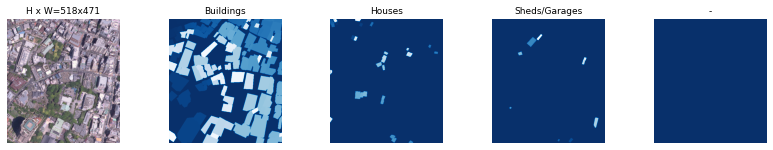

image                    shape: (518, 471, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (518, 471, 214)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (214,)                min:    1.00000  max:    3.00000  int32
bbox                     shape: (214, 4)              min:    0.00000  max:  518.00000  int32


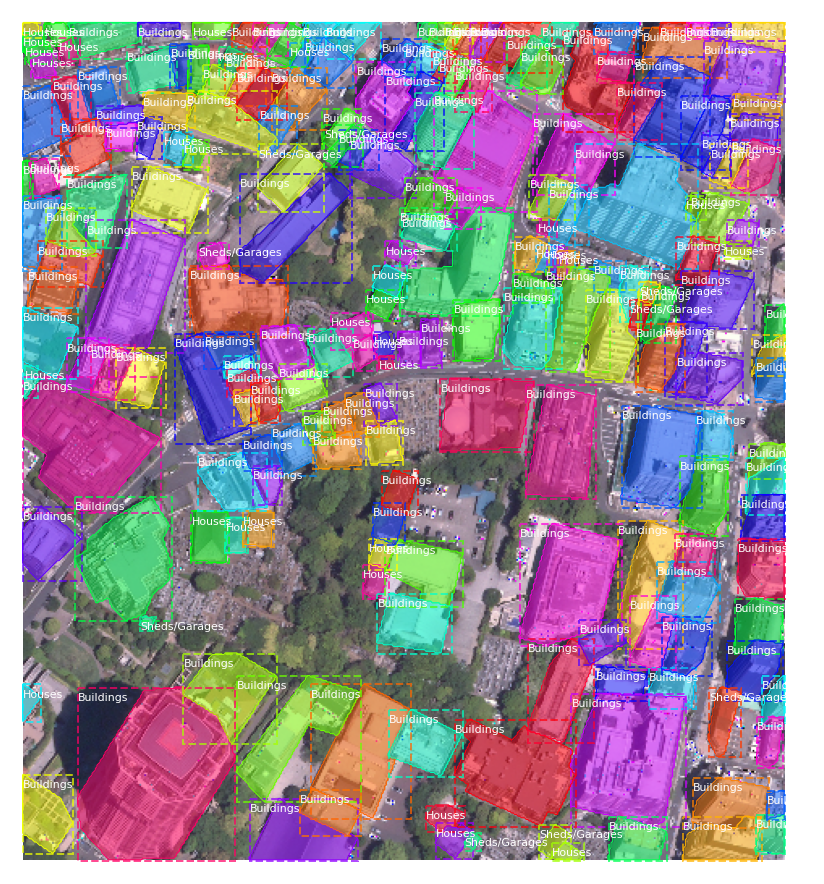

In [ ]:
# verify dataset
print('verifying random sample from the loaded dataset..')

# Load and display random sample from training dataset
image_id = random.choice(dataset_train.image_ids)
print('image ID', image_id)
print('image path', dataset_train.image_info[image_id]['path'])
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Display image and additional stats
bbox = utils.extract_bboxes(mask)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# print('image annotated data', dataset_train.image_reference(image_id))

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [ ]:
class SatelliteConfig(Config):
    """Configuration for training on the satellite dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # NOTE: Exception: Image size must be dividable by 2 at least 6 times to
          # avoid fractions when downscaling and upscaling.
          # For example, use 256, 320, 384, 448, 512, ... etc. 
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a large epoch since the data is complex
    STEPS_PER_EPOCH = 200 #1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10 #20 #50


    # Learning rate
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimizer
    # implementation.
    LEARNING_RATE = 0.01

config = SatelliteConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
## Create Model

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                        model_dir=MODEL_DIR)


# pick pre-trained model weights to start with
# init_with = "coco"  # imagenet, coco, or last
init_with = "imagenet"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                        "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

start_train = time.time()

#  Training - Stage 1
print("Training network heads")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')

# Training - Stage 2
# Finetune layers from ResNet stage 4 and up
print("Fine tune Resnet stage 4 and up")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='4+')

# Training - Stage 3
# Fine tune all layers
print("Fine tune all layers")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=30,
            layers='all')

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'total training took {minutes} minutes')


117/200 [================>.............] - ETA: 7:33 - loss: 0.7024 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.3267 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.2542

KeyboardInterrupt: ignored

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_satellite_manual.h5")
model.keras_model.save_weights(model_path)

In [ ]:
class InferenceConfig(SatelliteConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.2

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
print('most recent weight', model_path)

# Load trained weights
print("Loading weights from ", model_path)
model_path = '/content/Mask_RCNN/logs/shapes20210311T2358/mask_rcnn_shapes_0011.h5'
model.load_weights(model_path, by_name=True)

most recent weight /content/Mask_RCNN/logs/shapes20210311T2358/mask_rcnn_shapes_0022.h5
Loading weights from  /content/Mask_RCNN/logs/shapes20210311T2358/mask_rcnn_shapes_0022.h5
Re-starting from epoch 11


In [ ]:
# "Return a Matplotlib Axes array to be used in all visualizations in the notebook
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  518.00000  float64
gt_class_id              shape: (243,)                min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (243, 4)              min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 243)       min:    0.00000  max:    1.00000  bool


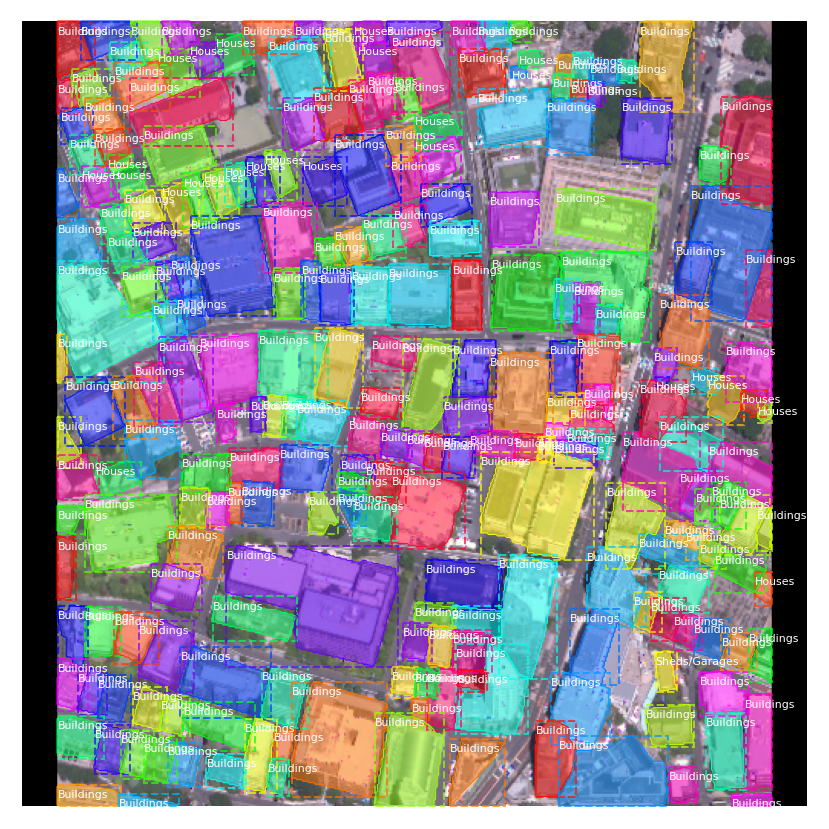

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config,
                                                            image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(15, 15))


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


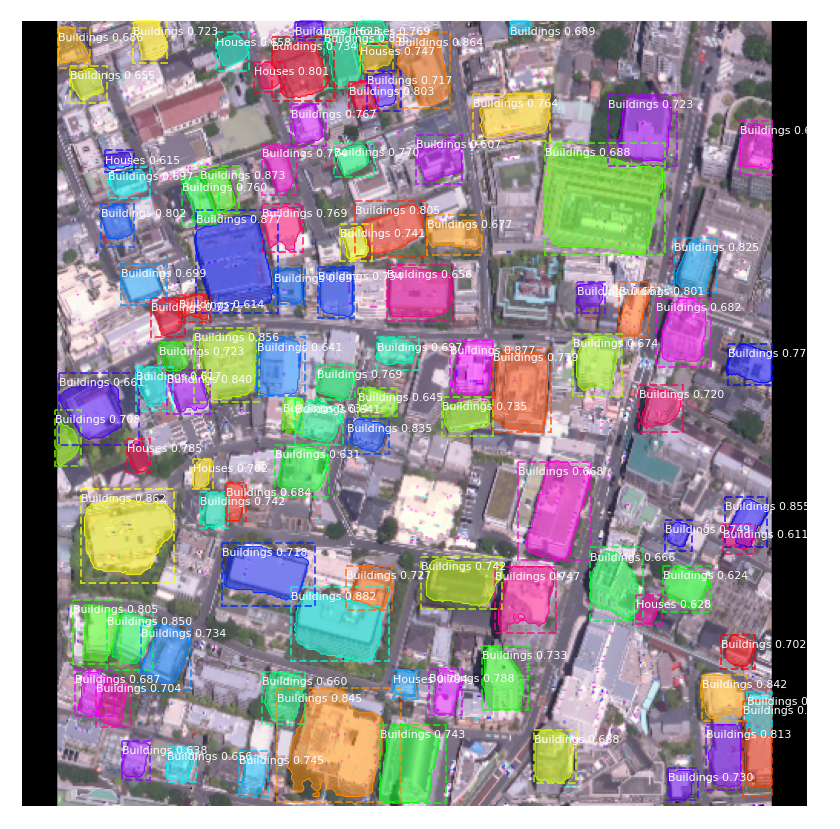

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'],figsize=(15, 15))

mAP:  0.1782991983460023


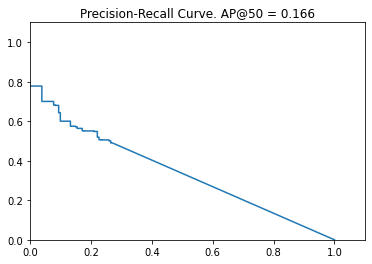

In [ ]:
image_ids = np.random.choice(dataset_val.image_ids, len(dataset_val.image_ids))
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config,
                                                      image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)

    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]

    # Compute AP
    AP, precisions, recalls, overlaps =  utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("mAP: ", np.mean(APs))

# visualize precision-recall curve
visualize.plot_precision_recall(AP, precisions, recalls)


In [ ]:
# too many instances, very complex plot
# Grid of ground truth objects and their predictions
# visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        # overlaps, dataset_val.class_names)

In [ ]:
# start tensorboard
# copy latest directory path here
%tensorboard --logdir /content/Mask_RCNN/logs



In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard
notebook.display(port=6006, height=1000) 

Known TensorBoard instances:
  - port 6006: logdir /content/Mask_RCNN/logs/shapes20210311T2358 (started 0:01:25 ago; pid 7204)
  - port 6007: logdir /content/Mask_RCNN/logs/ (started 0:00:12 ago; pid 7218)
  - port 6008: logdir /content/Mask_RCNN/logs (started 0:00:04 ago; pid 7226)
Selecting TensorBoard with logdir /content/Mask_RCNN/logs/shapes20210311T2358 (started 0:01:25 ago; port 6006, pid 7204).


In [ ]:
# So, you have 5 "small" losses:

# rpn_class_loss : How well the Region Proposal Network separates background with objetcs
# rpn_bbox_loss : How well the RPN localize objects
# mrcnn_bbox_loss : How well the Mask RCNN localize objects
# mrcnn_class_loss : How well the Mask RCNN recognize each class of object
# mrcnn_mask_loss : How well the Mask RCNN segment objects
# That makes a bigger loss:

# loss : A combination (surely an addition) of all the smaller losses.
# All of those losses are calculated on the training dataset.

# The losses for the validation dataset are those starting with 'val'


# more debugging here
# https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/inspect_model.ipynb
# https://github.com/matterport/Mask_RCNN/blob/master/samples/nucleus/inspect_nucleus_model.ipynb